[source](https://www.mathworks.com/help/optim/ug/sudoku-puzzles-problem-based.html)

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import gurobipy as gp
from gurobipy import GRB
import highspy

from utils.timer import Timer

from numba import njit

from utils.constraintUtils import *
from utils.formattingUtils import *
from utils.ILPUtils import *


In [2]:
#The sudoku from the problem
empty_sudoku = np.array(
   [[0, 0, 1, 0, 0, 0, 0, 0, 2],
    [0, 0, 0, 3, 0, 4, 5, 0, 0],
    [6, 0, 0, 7, 0, 0, 1, 0, 0],
    [0, 4, 0, 5, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 8, 0],
    [0, 0, 0, 0, 0, 6, 0, 9, 0],
    [0, 0, 5, 0, 0, 9, 0, 0, 4],
    [0, 0, 8, 2, 0, 1, 0, 0, 0],
    [3, 0, 0, 0, 0, 0, 7, 0, 0]]
)

#a sample sudoku from the internet
sample_solution = np.array(
    [[7, 1, 3, 5, 2, 4, 6, 9, 8],
     [5, 2, 9, 6, 1, 8, 3, 4, 7],
     [6, 4, 8, 7, 3, 9,	2, 5, 1],
     [1, 5, 2, 9, 4, 7, 8, 3, 6],
     [8, 3, 6, 1, 5, 2, 9, 7, 4],
     [4, 9, 7, 3, 8, 6, 5, 1, 2],
     [3, 8, 5, 4, 6, 1, 7, 2, 9],
     [9, 6,	1, 2, 7, 5, 4, 8, 3],
     [2, 7, 4, 8, 9, 3, 1, 6, 5]]
)

#the same sample sudoku with some elements deleted
empty_sample_solution = np.array(
    [[0, 0, 0, 5, 2, 4, 6, 9, 8],
     [5, 2, 0, 6, 1, 8, 3, 4, 7],
     [6, 4, 8, 7, 3, 9,	2, 5, 1],
     [1, 5, 2, 9, 4, 7, 8, 3, 6],
     [8, 3, 6, 1, 5, 2, 9, 7, 4],
     [4, 9, 7, 3, 8, 6, 5, 1, 2],
     [3, 8, 5, 4, 6, 1, 7, 2, 9],
     [9, 6,	1, 2, 7, 5, 4, 8, 3],
     [2, 7, 4, 8, 9, 3, 1, 6, 5]]
)

#A very empty sudoku
very_empty_clues = np.zeros((9,9), dtype = int)
very_empty_clues[0,1] = 3
very_empty_clues[0,2] = 2
very_empty_clues[0,3] = 1

In [3]:
bin_sample_solution = array_to_vector(sample_solution)
vector_to_array(bin_sample_solution)

array([[7, 1, 3, 5, 2, 4, 6, 9, 8],
       [5, 2, 9, 6, 1, 8, 3, 4, 7],
       [6, 4, 8, 7, 3, 9, 2, 5, 1],
       [1, 5, 2, 9, 4, 7, 8, 3, 6],
       [8, 3, 6, 1, 5, 2, 9, 7, 4],
       [4, 9, 7, 3, 8, 6, 5, 1, 2],
       [3, 8, 5, 4, 6, 1, 7, 2, 9],
       [9, 6, 1, 2, 7, 5, 4, 8, 3],
       [2, 7, 4, 8, 9, 3, 1, 6, 5]])

In [4]:
def setup_ILP_sparse(clue_array, format = "csr", dtype = int):
    clues_inds_rows, clues_inds_cols, clues_vals = sudoku_array_to_clues(clue_array)
    
    A_one_val = generate_one_value_constr_sparse(format = format, dtype = dtype)
    A_row = generate_row_uniq_constr_sparse(format = format, dtype = dtype)
    A_col = generate_col_uniq_constr_sparse(format = format, dtype = dtype)
    A_block = generate_block_uniq_constr_sparse(format = format, dtype = dtype)
    A_clues = generate_clues_contr_sparse(clues_inds_rows, clues_inds_cols, clues_vals, format = format, dtype = dtype)

    A_full = sp.sparse.vstack((A_one_val, A_row, A_col, A_block, A_clues), format = format)
    c = np.linspace(0,1,A_full.shape[1]) #np.zeros(solution_size, dtype = np.float64)
    return c, A_full, A_one_val, A_row, A_col, A_block, A_clues

In [5]:
c, A_full, A_one_val, A_row, A_col, A_block, A_clues = setup_ILP_sparse(empty_sudoku, format = "csr", dtype = int)

In [8]:
clues_inds_rows, clues_inds_cols, clues_vals = sudoku_array_to_clues(empty_sudoku)

row_inds = np.arange(clues_vals.shape[0])
col_inds = NVALS*NCOLS*clues_inds_rows + NVALS*clues_inds_cols + clues_vals-1

In [9]:
row_inds

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

In [10]:
col_inds

array([ 18,  73, 110, 129, 139, 167, 195, 216, 255, 274, 334, 394, 455,
       476, 508, 539, 561, 592, 595, 612, 650, 708])

In [11]:
A_clues.indices

array([ 18,  73, 110, 129, 139, 167, 195, 216, 255, 274, 334, 394, 455,
       476, 508, 539, 561, 592, 595, 612, 650, 708], dtype=int32)

In [12]:
A_clues.indptr

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22], dtype=int32)

In [ ]:
indptr = np.hstack([i*np.ones(n, dtype = int) for i, n in enumerate([col_inds[0]+1, *np.diff(col_inds), 9**3-col_inds[-1]])])
indptr - A_clues.indptr

In [ ]:
indices = row_inds
indptr = 

In [ ]:
A_clues.data - np.ones_like(row_inds)

In [ ]:
A_clues.indices - row_inds

In [ ]:
# tot = -1
# for value in set(A_clues.indptr):
#     tot += len(np.where(A_clues.indptr == value)[0])
#     print(tot)

In [ ]:
A_clues.indptr

In [30]:
kron_sum(np.arange(0,9,1), np.arange(0,81,9)).flatten()

array([ 0,  9, 18, 27, 36, 45, 54, 63, 72,  1, 10, 19, 28, 37, 46, 55, 64,
       73,  2, 11, 20, 29, 38, 47, 56, 65, 74,  3, 12, 21, 30, 39, 48, 57,
       66, 75,  4, 13, 22, 31, 40, 49, 58, 67, 76,  5, 14, 23, 32, 41, 50,
       59, 68, 77,  6, 15, 24, 33, 42, 51, 60, 69, 78,  7, 16, 25, 34, 43,
       52, 61, 70, 79,  8, 17, 26, 35, 44, 53, 62, 71, 80])

In [32]:
(np.arange(0,9,1)[:,None] + np.arange(0,81,9)[None,:]).flatten()

array([ 0,  9, 18, 27, 36, 45, 54, 63, 72,  1, 10, 19, 28, 37, 46, 55, 64,
       73,  2, 11, 20, 29, 38, 47, 56, 65, 74,  3, 12, 21, 30, 39, 48, 57,
       66, 75,  4, 13, 22, 31, 40, 49, 58, 67, 76,  5, 14, 23, 32, 41, 50,
       59, 68, 77,  6, 15, 24, 33, 42, 51, 60, 69, 78,  7, 16, 25, 34, 43,
       52, 61, 70, 79,  8, 17, 26, 35, 44, 53, 62, 71, 80])

In [33]:
@njit
def kron_sum(a,b):
    return (a[:,None] + b[None,:]).flatten()

In [35]:
kron_sum(np.arange(0,9,1), np.arange(0,81,9))

array([ 0,  9, 18, 27, 36, 45, 54, 63, 72,  1, 10, 19, 28, 37, 46, 55, 64,
       73,  2, 11, 20, 29, 38, 47, 56, 65, 74,  3, 12, 21, 30, 39, 48, 57,
       66, 75,  4, 13, 22, 31, 40, 49, 58, 67, 76,  5, 14, 23, 32, 41, 50,
       59, 68, 77,  6, 15, 24, 33, 42, 51, 60, 69, 78,  7, 16, 25, 34, 43,
       52, 61, 70, 79,  8, 17, 26, 35, 44, 53, 62, 71, 80])

In [26]:
numba.uint32

uint32

In [147]:
A_one_val.indices
A_one_val.indptr

@njit
def generate_sparse_one_val(dtype = numba.uint32):
    indices = np.arange(0,NCOLS*NROWS*NVALS,)
    indptr = np.arange(0, (NCOLS*NROWS*NVALS+1), NVALS)
    data = np.ones((NCOLS*NROWS*NVALS), dtype = dtype)
    return data, indices, indptr

@njit
def generate_sparse_row(dtype = numba.uint32):
    indices = kron_sum(np.arange(0,9**3, 9**2), kron_sum(np.arange(0,9,1), np.arange(0,81,9)))   
    indptr = np.arange(0, (NCOLS*NROWS*NVALS+1), NVALS)
    data = np.ones((NCOLS*NROWS*NVALS), dtype = dtype)
    return data, indices, indptr

@njit
def generate_sparse_col(dtype = numba.uint32):
    indices = kron_sum(np.arange(0,81,1), np.arange(0,9**3, 9**2))
    indptr = np.arange(0, (NCOLS*NROWS*NVALS+1), NVALS)
    data = np.ones((NCOLS*NROWS*NVALS), dtype = dtype)
    return data, indices, indptr

@njit
def generate_sparse_block(dtype = numba.uint32):
    indices = kron_sum(np.arange(0,9**3, 9**2*3), kron_sum( np.arange(0, 9*9, 9*3), kron_sum(np.arange(0,9,1), kron_sum(np.arange(0,9**2*3,9**2), np.arange(0,3*9, 9)))))
    indptr = np.arange(0, (NCOLS*NROWS*NVALS+1), NVALS)
    data = np.ones((NCOLS*NROWS*NVALS), dtype = dtype)
    return data, indices, indptr

@njit
def generate_sparse_clues(clues_inds_rows, clues_inds_cols, clues_vals, dtype = numba.uint32):
    row_inds = np.arange(clues_vals.shape[0])
    col_inds = NVALS*NCOLS*clues_inds_rows + NVALS*clues_inds_cols + clues_vals-1
    indices = col_inds
    indptr = np.arange(row_inds.shape[0]+1)
    data = np.ones((len(col_inds)), dtype = dtype)
    return data, indices, indptr

@njit
def generate_sparse_constaints(clues_array):
    data_0, indices_0, indptr_0 = generate_sparse_one_val()
    data_1, indices_1, indptr_1 = generate_sparse_row()
    data_2, indices_2, indptr_2 = generate_sparse_col()
    data_3, indices_3, indptr_3 = generate_sparse_block()
    clues_inds_rows, clues_inds_cols, clues_vals = sudoku_array_to_clues_njit(empty_sudoku)
    data_4, indices_4, indptr_4 = generate_sparse_clues(clues_inds_rows, clues_inds_cols, clues_vals)

    data_list = [data_0, data_1, data_2, data_3, data_4]
    indices_list = [indices_0, indices_1, indices_2, indices_3, indices_4]
    indptr_list = [indptr_0, indptr_1, indptr_2, indptr_3, indptr_4]
    shape_list = [(9**2, 9**3), (9**2, 9**3), (9**2, 9**3), (9**2, 9**3), (len(indptr_list[4]), 9**3)]
    
    return data_list, indices_list, indptr_list, shape_list

@njit
def concat(arr_list):
    return [j for arr in arr_list for j in arr]

@njit
def count_concat(arr_list):
    offset = 0
    new_arr_list = arr_list #[None]*len(arr_list)#np.empty((len(arr_list))).tolist()
    for i, arr in enumerate(arr_list):
        new_arr_list[i] =  arr + offset
        offset += arr[-1]
    return concat(new_arr_list)

@njit
def stack_sparse_matrices(data_list, indices_list, indptr_list, shape_list):
    data = concat(data_list)
    indices = concat(indices_list)
    indptr = count_concat([indptr_list[1]] + [indices[1:] for indices in indptr_list[1:]])
    shape = (sum( [shape[0] for shape in shape_list])-1, 9**3)
    return data, indices, indptr, shape



    



In [149]:
data_list, indices_list, indptr_list, shape_list = generate_sparse_constaints(empty_sudoku)

data, indices, indptr, shape = stack_sparse_matrices(data_list, indices_list, indptr_list, shape_list)

In [41]:
A_one_val_sparse = sp.sparse.csr_matrix(generate_sparse_one_val())
print((A_one_val_sparse - A_one_val).data)
A_row_sparse = sp.sparse.csr_matrix(generate_sparse_row())
print((A_row_sparse - A_row).data)
A_col_sparse = sp.sparse.csr_matrix(generate_sparse_col())
print((A_col_sparse - A_col).data)
A_block_sparse = sp.sparse.csr_matrix(generate_sparse_block())
print((A_block_sparse - A_block).data)

clues_inds_rows, clues_inds_cols, clues_vals = sudoku_array_to_clues(empty_sudoku)
A_clues_sparse = sp.sparse.csr_matrix(generate_sparse_clues(data, indices, indptr), shape = (len(indptr), 9**3))
print((A_clues_sparse - A_clues).data)



[]
[]
[]
[]
[]


In [55]:
A_clues.shape

(22, 729)

In [130]:

import itertools





A_full_sparse = sp.sparse.csr_matrix((data, indices, indptr))#, shape = shape)

[0, 9, 18, 27, 36, 45, 54, 63, 72, 81, 90, 99, 108, 117, 126, 135, 144, 153, 162, 171, 180, 189, 198, 207, 216, 225, 234, 243, 252, 261, 270, 279, 288, 297, 306, 315, 324, 333, 342, 351, 360, 369, 378, 387, 396, 405, 414, 423, 432, 441, 450, 459, 468, 477, 486, 495, 504, 513, 522, 531, 540, 549, 558, 567, 576, 585, 594, 603, 612, 621, 630, 639, 648, 657, 666, 675, 684, 693, 702, 711, 720, 729, 738, 747, 756, 765, 774, 783, 792, 801, 810, 819, 828, 837, 846, 855, 864, 873, 882, 891, 900, 909, 918, 927, 936, 945, 954, 963, 972, 981, 990, 999, 1008, 1017, 1026, 1035, 1044, 1053, 1062, 1071, 1080, 1089, 1098, 1107, 1116, 1125, 1134, 1143, 1152, 1161, 1170, 1179, 1188, 1197, 1206, 1215, 1224, 1233, 1242, 1251, 1260, 1269, 1278, 1287, 1296, 1305, 1314, 1323, 1332, 1341, 1350, 1359, 1368, 1377, 1386, 1395, 1404, 1413, 1422, 1431, 1440, 1449, 1458, 1467, 1476, 1485, 1494, 1503, 1512, 1521, 1530, 1539, 1548, 1557, 1566, 1575, 1584, 1593, 1602, 1611, 1620, 1629, 1638, 1647, 1656, 1665, 1674, 168

In [131]:
(A_full_sparse - A_full).data

array([], dtype=int64)

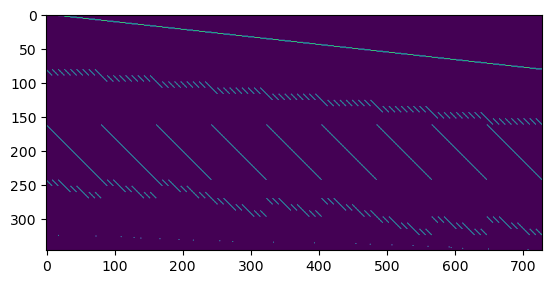

In [132]:
plt.imshow(A_full_sparse.todense())

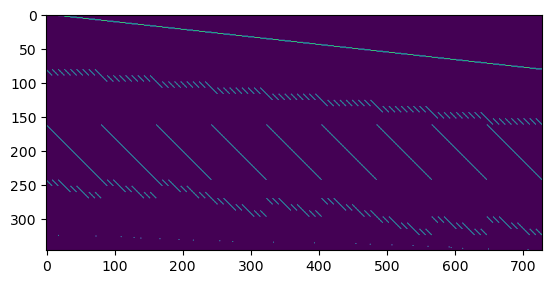

In [73]:
plt.imshow(A_full.todense())

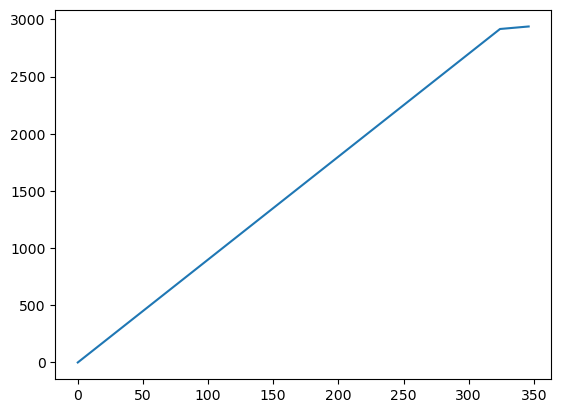

In [67]:
plt.plot(A_full.indptr)

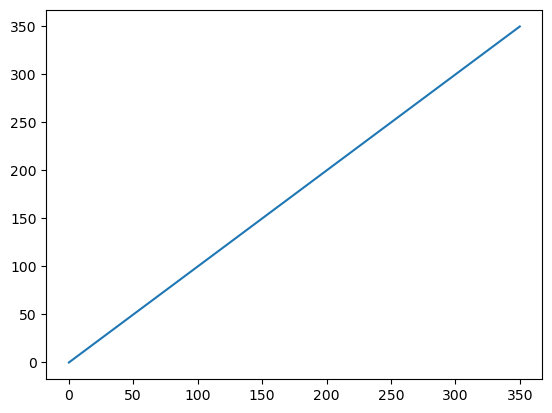

In [68]:
plt.plot(indptr)

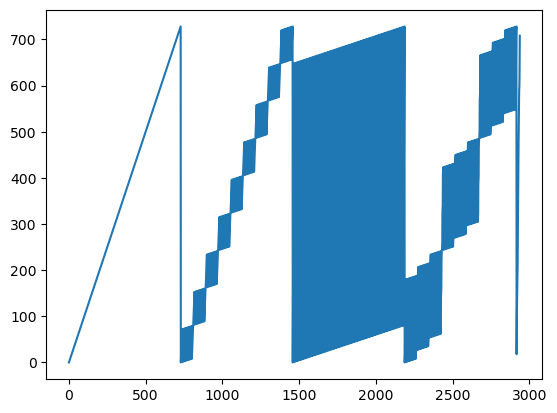

In [65]:
plt.plot(A_full.indices)

In [ ]:
a, A = setup_ILP_njit(empty_sudoku)
plt.imshow(A)
A_csr = sp.sparse.csr_matrix(A)

In [ ]:
print(A_csr.indices[-20:])

In [ ]:
A_csr.indptr

In [ ]:
with Timer("njitted"):
    setup_ILP_njit(empty_sudoku)

with Timer("normal"):
    setup_ILP_dense(empty_sudoku)

print(Timer.timers)

In [ ]:


def solve_sudoku_scipy(c, A_full):
    solution_size = A_full.shape[1]
    integrality = np.ones(solution_size, dtype = int)
    bounds = sp.optimize.Bounds(lb=0, ub=1) #somthing with 0 and 
    constraints = sp.optimize.LinearConstraint(A_full, lb=1, ub=1) #somthing with A
    res = sp.optimize.milp(c, integrality = integrality, bounds = bounds, constraints = constraints)
    return res

env = gp.Env(empty=True)
env.setParam('OutputFlag', 0)
env.start()
        
def solve_sudoku_gurobi(c, A_full):
    # Create a new model
    m = gp.Model("matrix1", env = env) 
    # Create variables
    solution_size = A_full.shape[1]
    x = m.addMVar(shape=solution_size, vtype=GRB.BINARY, name="x")
    # Build rhs vector
    rhs = np.ones(A_full.shape[0], dtype = int)
    # Add constraints
    m.addConstr(A_full @ x == rhs, name="constraints")
    # Set objective
    m.setObjective(c @ x, GRB.MINIMIZE)
    # Optimize model
    m.optimize()
    return x.X
    

def solve_sudoku_highspy(c, A_full):

    rows, cols = A_full.shape
    # Highs h
    h = highspy.Highs()

    # Define a HighsLp instance
    lp = highspy.HighsLp()
    
    lp.num_col_ = cols
    lp.num_row_ = rows
    lp.col_cost_ = c
    lp.col_lower_ = np.zeros(c.shape, dtype = int)
    lp.col_upper_ = np.ones(c.shape, dtype = int)
    lp.row_lower_ = np.ones((rows), dtype = int)
    lp.row_upper_ = np.ones((rows), dtype = int)
    lp.integrality_ = [highspy._core.HighsVarType.kInteger]*cols # np.ones(c.shape, dtype = int).tolist()
    #lp.integrality_ = 1#np.ones(c.shape, dtype = int)#highspy.HighsVarType.kInteger
    
    # In a HighsLp instsance, the number of nonzeros is given by a fictitious final start
    lp.a_matrix_.format_ = highspy.MatrixFormat.kColwise
    lp.a_matrix_.start_ = A_full.indptr
    lp.a_matrix_.index_ = A_full.indices
    lp.a_matrix_.value_ = A_full.data
    h.passModel(lp)

    # Get and set options
    options = h.getOptions()
    options.log_to_console = False
    h.passOptions(options)

    h.run()
    
    solution = h.getSolution()
    x= np.array(solution.col_value)
    return x

from pyscipopt import Model
model = Model()

def solve_sudoku_pisciopt(c, A_full):
    num_constr, num_vars = A_full.shape 
    x = model.addVar("x", num_vars, vtype="binary")
    #model.setObjective(c @ x)
    #model.addCons(A_full@x == 0)
    #model.addCons(2*x - y*y >= 0)
    
    return model

        





In [ ]:
with Timer("Solve Highs"):
    c, A_full_njit = setup_ILP_njit(empty_sudoku)
    A_full_njit_sparse = sp.sparse.csc_matrix(A_full_njit)
    #model = solve_sudoku_pisciopt(c, A_full_njit)
    solution = solve_sudoku_highspy(c, A_full_njit_sparse)

print(vector_to_array(solution))
print(Timer.timers)

In [ ]:
# %load_ext line_profiler
# %lprun -f solve_sudoku_highspy res_scipy = solve_sudoku_highspy(c, A_full_njit_sparse)

In [ ]:

# %load_ext line_profiler
    
# %lprun -f setup_ILP_dense c, A_full_dense = setup_ILP_dense(empty_sudoku, dtype = bool)

# %lprun -f solve_sudoku_scipy res_scipy = solve_sudoku_scipy(c, A_full_dense)
# %lprun -f setup_ILP_sparse c, A_full_dense = setup_ILP_sparse(empty_sudoku, dtype = bool)



In [ ]:
#fastest option
with Timer("Solve sudoku"):
    c, A_full_njit = setup_ILP_njit(empty_sudoku)
    A_sparse_njit =  sp.sparse.csr_matrix(A_full_njit)
    res_scipy = solve_sudoku_scipy(c, A_sparse_njit)
    

print(Timer.timers)
    
    

In [ ]:
#fastest option

c, A_full_njit = setup_ILP_njit(empty_sudoku)

for i in range(10):
    A_sparse_njit =  sp.sparse.csr_matrix(A_full_njit)
    with Timer("CSR"):
        solve_sudoku_scipy(c, A_sparse_njit)
    
    A_sparse_njit =  sp.sparse.csc_matrix(A_full_njit)
    with Timer("CSC"):
        solve_sudoku_scipy(c, A_sparse_njit)
    

print(Timer.timers)
    

In [ ]:
repeats = 8
for i in range(repeats):
    with Timer("1. Setup njit dense"):
        c, A_full_njit_dense = setup_ILP_njit(empty_sudoku)
    with Timer("2. Scipy solver njit dense"):
        res_scipy = solve_sudoku_scipy(c, A_full_njit_dense)
    with Timer("3. Gurobi solver njit dense"):
        res_gurobi = solve_sudoku_gurobi(c, A_full_njit_dense )
    del c
    del A_full_njit_dense 

    with Timer("1. Setup njit sparse"):
        c, A_full_njit_dense = setup_ILP_njit(empty_sudoku)
        A_full_njit_sparse = sp.sparse.csc_matrix(A_full_njit_dense)
    with Timer("2. Scipy solver njit sparse"):
        res_scipy = solve_sudoku_scipy(c, A_full_njit_sparse )
    with Timer("3. Gurobi solver njit sparse"):
        res_gurobi = solve_sudoku_gurobi(c, A_full_njit_sparse )
    with Timer("4. Highspy solver njit sparse"):
        res_highspy = solve_sudoku_highspy(c, A_full_njit_sparse )
    del c
    del A_full_njit_sparse
        
    with Timer("1. Setup sparse_dense"):
        c, A_full_sparse = setup_ILP_sparse_end(empty_sudoku, format = "csc", dtype = bool)
    with Timer("2. Scipy solver sparse_dense"):
        res_scipy = solve_sudoku_scipy(c, A_full_sparse)
    with Timer("3. Gurobi solver sparse_dense"):
        res_gurobi = solve_sudoku_gurobi(c, A_full_sparse)
    del c
    del A_full_sparse
    
    with Timer("1. Setup sparse"):
        c, A_full_sparse = setup_ILP_sparse(empty_sudoku, format = "csc", dtype = bool)
    with Timer("2. Scipy solver sparse"):
        res_scipy = solve_sudoku_scipy(c, A_full_sparse)
    with Timer("3. Gurobi solver sparse"):
        res_gurobi = solve_sudoku_gurobi(c, A_full_sparse)
    del c
    del A_full_sparse
    
    with Timer("1. Setup dense"):
        c, A_full_dense = setup_ILP_dense(empty_sudoku, dtype = bool)
    with Timer("2. Scipy solver dense"):
        res_scipy = solve_sudoku_scipy(c, A_full_dense)
    with Timer("3. Gurobi solver dense"):
        res_gurobi = solve_sudoku_gurobi(c, A_full_dense)
    del c
    del A_full_dense

np.set_printoptions(precision=5)
keys = np.sort(list(Timer.timers.keys()))
for key in keys:
    print(key, "\t\t", np.array(Timer.timers[key]))